In [5]:
!pip install pyworld
!pip install soundfile
!pip install scipy

    100% |████████████████████████████████| 81kB 2.4MB/s 
    100% |████████████████████████████████| 3.0MB 402kB/s 
  Running setup.py bdist_wheel for pyworld ... - error
  Complete output from command /usr/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-Iroxav/pyworld/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmpBuryi4pip-wheel- --python-tag cp27:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-2.7
  creating build/lib.linux-x86_64-2.7/pyworld
  copying pyworld/__init__.py -> build/lib.linux-x86_64-2.7/pyworld
  running build_ext
  building 'pyworld.pyworld' extension
  creating build/temp.linux-x86_64-2.7
  creating build/temp.linux-x86_64-2.7/pyworld
  creating build/temp.linux-x86_64-2.7/lib
  creating build/temp.linux-x86_64-2.7/lib/World
  creating build/temp.linux-x86_64-2.7/lib/

In [8]:
import pyworld as pw
from scipy.io import wavfile as wf
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

def upload_stuff():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
    with open(fn, 'w') as f:
      f.write(uploaded[fn])
  
  return uploaded
!ls

datalab


In [9]:
upload_stuff()
!ls

User uploaded file "clip1.wav" with length 1275726 bytes
clip1.wav  datalab


In [0]:
file = 'clip1.wav'

fs, x = wf.read(file)

Nwindows = 804
(804, 1025)


Text(0,0.5,u'band aperiodicities')

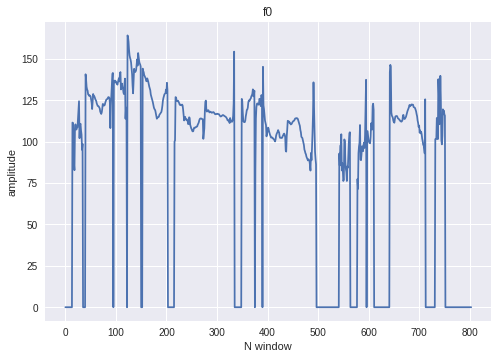

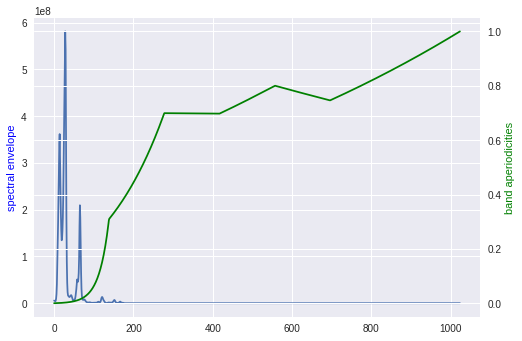

In [6]:
if x.ndim is 2:
    x = x[:, 0].squeeze()
    
x = x.copy(order='C')

f0, sp, ap = pw.wav2world(x.astype(float), fs)

Nwindows = f0.shape[0]
print("Nwindows = %d" % Nwindows)
print(sp.shape)


plt.figure()
plt.plot(range(Nwindows), f0)
plt.title("f0")
plt.xlabel("N window")
plt.ylabel("amplitude")




plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(sp[250,1:])
ax1.set_ylabel('spectral envelope', color='b')
ax2.plot(ap[250,1:], 'g')
ax2.set_ylabel('band aperiodicities', color='g')


In [7]:
upload_stuff()
!ls

NameError: ignored

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [42]:
# Dynamic time warping
import torch

from scipy.io import wavfile as wf
file_alberto = 'alberto.wav'
file_javi = 'alberto.wav'

fs, x_alberto = wf.read(file_alberto)
fs, x_javi = wf.read(file_javi)


def elementwyse_l2(x, y=None):
  
  # todo: use X^2 + y^2 - 2*X*Y for memory efficiency
  
  if y is None:
    y = x
  # input 
  #Nx = x.shape[0]
  #Ny = y.shape[0]
  #dims = x.shape[1]
  
  dist = (x.unsqueeze(1) - y.unsqueeze(0)).pow(2).sum(2)
  return dist

def genate_Cmtx(dists):  
  sz = dists.shape
  c = dists
  d = 100000*torch.ones(sz)
  #torch:
  #sz[0] = i vertical
  #sz[1] = j horizontal
  d[:, 0] = c[:, 0]
  
  for j in range(1, sz[1]):
    for i in range(sz[0]):

      if i is 0:
        d[i, j] = c[i,j] + d[i,j-1]
      else:
        d[i, j] = c[i,j] + torch.FloatTensor([d[i,j-1], d[i-1,j], d[i-1,j-1]]).min()
        
  return d

def dtw_backtracking(c, start):
  
  posV = start[0]
  posH = start[1]
  i = 0
  
  while posH != 1:
    
    if pos1(i) == 1:
      opts = 2;
      addcost = cost(pos1(i), pos2(i) - 1);

      else:
        opt1 = cost(pos1(i) - 1, pos2(i));
        opt2 = cost(pos1(i), pos2(i) - 1);
        opt3 = cost(pos1(i) - 1, pos2(i) - 1);
        [addcost, opts] = min([opt1; opt2; opt3]);

    
    i += 1
    
  
  
  
  return None


XA = torch.ones(4,2)
XJ = torch.ones(6,2)*3

D = elementwyse_l2(XA, XJ)
C = genate_Cmtx(D)
print(C)


  


  8  16  24  32  40  48
  8  16  24  32  40  48
  8  16  24  32  40  48
  8  16  24  32  40  48
[torch.FloatTensor of size 4x6]



In [49]:
x = np.eye(3)
x[0, 1] += 1
print(x)
print(x.shape)

[[1. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(3, 3)


In [0]:
######################################################################### Alberto

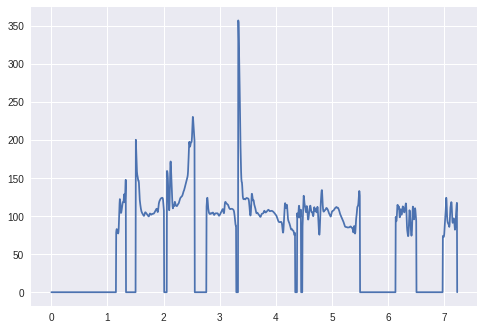

In [13]:
import pyworld as pw
from scipy.io import wavfile as wf
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

file = 'clip1.wav'

fs, x = wf.read(file)

if x.ndim is 2:
    x = x[:, 0].squeeze()
    
x = x.copy(order='C').astype(float)


In [0]:
"""Harvest F0 extraction algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    fs : int
        Sample rate of input signal in Hz.
    f0_floor : float
        Lower F0 limit in Hz.
        Default: 71.0
    f0_ceil : float
        Upper F0 limit in Hz.
        Default: 800.0
    frame_period : float
        Period between consecutive frames in milliseconds.
        Default: 5.0
    Returns
    -------
    f0 : ndarray
        Estimated F0 contour.
    temporal_positions : ndarray
        Temporal position of each frame.
    """

f0_floor = 71.0
f0_ceil = 800.0
frame_period = 5.0
f0, temporal_positions = pw.harvest(x, fs,f0_floor, f0_ceil, frame_period)

#plt.figure()
#plt.plot(temporal_positions, f0)


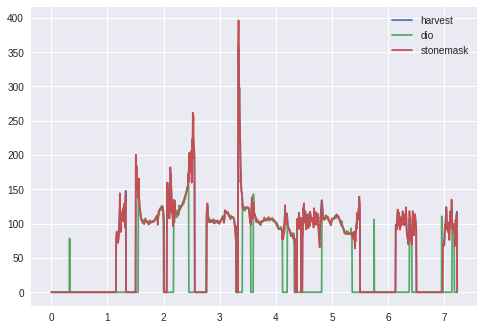

In [40]:
"""DIO F0 extraction algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    fs : int
        Sample rate of input signal in Hz.
    f0_floor : float
        Lower F0 limit in Hz.
        Default: 71.0
    f0_ceil : float
        Upper F0 limit in Hz.
        Default: 800.0
    channels_in_octave : float
        Resolution of multiband processing; normally shouldn't be changed.
        Default: 2.0
    frame_period : float
        Period between consecutive frames in milliseconds.
        Default: 5.0
    speed : int
        The F0 estimator may downsample the input signal using this integer factor
        (range [1;12]). The algorithm will then operate on a signal at fs/speed Hz
        to reduce computational complexity, but high values may negatively impact
        accuracy.
        Default: 1 (no downsampling)
    allowed_range : float
        Threshold for voiced/unvoiced decision. Can be any value >= 0, but 0.02 to 0.2
        is a reasonable range. Lower values will cause more frames to be considered
        unvoiced (in the extreme case of `threshold=0`, almost all frames will be unvoiced).
        Default: 0.1
    Returns
    -------
    f0 : ndarray
        Estimated F0 contour.
    temporal_positions : ndarray
        Temporal position of each frame.
    """

f0_floor = 71.0
f0_ceil = 800.0
channels_in_octave = 2.0
frame_period = 5
speed= 1
allowed_range = 0.1
f0_dio, temporal_positions = pw.dio(x, fs,f0_floor, f0_ceil, channels_in_octave, 
                                frame_period, speed, allowed_range)

"""StoneMask F0 refinement algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    f0 : ndarray
        Input F0 contour.
    temporal_positions : ndarray
        Temporal positions of each frame.
    fs : int
        Sample rate of input signal in Hz.
    Returns
    -------
    refined_f0 : ndarray
        Refined F0 contour.
    """
f0_sm = pw.stonemask(x, f0, temporal_positions, fs)

plt.figure()
plt.plot(temporal_positions, f0, label="harvest")
plt.plot(temporal_positions, f0_dio, label="dio")
plt.plot(temporal_positions, f0_sm, label="stonemask")

plt.legend()

(1447, 1025)


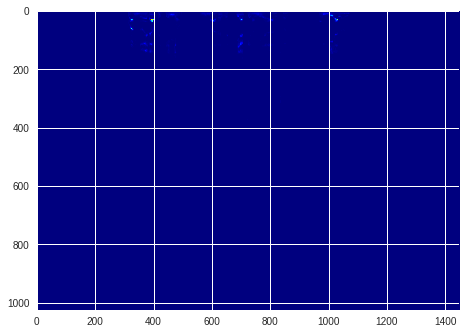

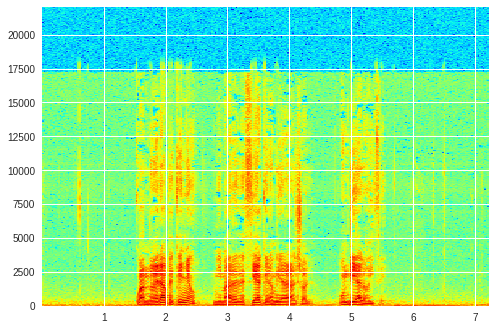

In [78]:
"""CheapTrick harmonic spectral envelope estimation algorithm.
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    f0 : ndarray
        Input F0 contour.
    temporal_positions : ndarray
        Temporal positions of each frame.
    fs : int
        Sample rate of input signal in Hz.
    q1 : float
        Spectral recovery parameter.
        Default: -0.15 (this value was tuned and normally does not need adjustment)
    f0_floor : float, None
        Lower F0 limit in Hz. Not used in case `fft_size` is specified.
        Default: 71.0
    fft_size : int, None
        FFT size to be used. When `None` (default) is used, the FFT size is computed
        automatically as a function of the given input sample rate and F0 floor.
        When `fft_size` is specified, the given `f0_floor` parameter is ignored.
        Default: None
    Returns
    -------
    spectrogram : ndarray
        Spectral envelope (squared magnitude).
    """
f0_sp = f0;
q1 = -0.15
f0_floor = 71.0
fft_size = pw.get_cheaptrick_fft_size(fs,f0_floor)

ap = pw.cheaptrick(x, f0, temporal_positions, fs, q1, f0_floor, fft_size)
print(ap.shape)
plt.figure()
plt.imshow(ap.T, cmap="jet")

plt.figure()
Pxx, freqs, bins, im = plt.specgram(x, NFFT=fft_size, Fs=fs, noverlap=900,cmap="jet")
plt.show()

